# Goemans-Williamson algorithm for Maxcut problem
This notebook implements the Goemans-Williamson algorithm, runs time-budgeted experiments on multiple random graphs per size, and saves results for later statistical analysis.

In [7]:
import networkx as nx
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
import os
from datetime import datetime

## Graph generation

In [8]:
def generate_random_graph(n_nodes=8, p=0.5, seed=None):
    G = nx.erdos_renyi_graph(n_nodes, p, seed=seed)
    for (u, v) in G.edges():
        G.edges[u, v]['weight'] = np.random.randint(1, 10)
    return G

## Algorithm

In [9]:
def goemans_williamson_maxcut(G, num_rounds=50, seed=None):
    np.random.seed(seed)
    n = G.number_of_nodes()
    W = nx.to_numpy_array(G, weight='weight')
    
    # SDP relaxation
    X = cp.Variable((n, n), symmetric=True)
    constraints = [X >> 0, cp.diag(X) == 1]
    objective = cp.Maximize(0.25 * cp.sum(cp.multiply(W, 1 - X)))
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS, verbose=False)
    X_opt = X.value

    # Randomized hyperplane rounding
    vals, vecs = np.linalg.eigh(X_opt)
    V = vecs @ np.diag(np.sqrt(np.maximum(vals, 0)))
    best_cut = None
    best_value = -np.inf
    for _ in range(num_rounds):
        r = np.random.randn(n)
        r /= np.linalg.norm(r)
        assignment = V @ r > 0
        cut_value = 0
        for i, j in G.edges():
            if assignment[i] != assignment[j]:
                cut_value += G.edges[i, j]['weight']
        if cut_value > best_value:
            best_value = cut_value
            best_cut = assignment
    return best_cut, best_value

## Test of functionality

Best cut value: 72


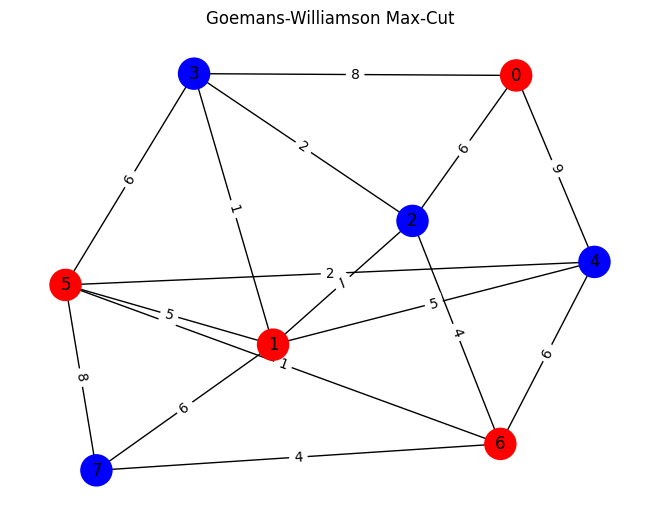

In [10]:
G = generate_random_graph(n_nodes=8, p=0.5, seed=42)
cut, value = goemans_williamson_maxcut(G, num_rounds=100, seed=42)
print(f"Best cut value: {value}")

def plot_cut(G, cut):
    pos = nx.spring_layout(G, seed=42)
    colors = ['red' if cut[node] else 'blue' for node in G.nodes()]
    nx.draw(G, pos, with_labels=True, node_color=colors, node_size=500)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.title("Goemans-Williamson Max-Cut")
    plt.show()

plot_cut(G, cut)

## Experiment function

In [11]:
def run_gw_experiment_time_budget(sizes, edge_prob=0.5, time_per_size=420, num_rounds=50):
    all_cut_values = []
    for n_nodes in sizes:
        cut_values = []
        start_time = time.time()
        g_idx = 0
        while time.time() - start_time < time_per_size:
            G = generate_random_graph(n_nodes=n_nodes, p=edge_prob, seed=g_idx)
            cut, value = goemans_williamson_maxcut(G, num_rounds=num_rounds)
            cut_values.append(value)
            g_idx += 1
        all_cut_values.append(cut_values)
        print(f"Size: {n_nodes} | Graphs: {g_idx} | Mean Cut: {np.mean(cut_values):.2f} | Std: {np.std(cut_values):.2f}")
    return all_cut_values

# Experiment + plot

Size: 25 | Graphs: 773 | Mean Cut: 517.35 | Std: 33.44
Size: 50 | Graphs: 132 | Mean Cut: 1934.61 | Std: 67.06
Size: 75 | Graphs: 42 | Mean Cut: 4213.10 | Std: 99.32
Size: 100 | Graphs: 17 | Mean Cut: 7306.71 | Std: 93.95
Size: 125 | Graphs: 8 | Mean Cut: 11320.50 | Std: 140.54
Size: 150 | Graphs: 6 | Mean Cut: 16014.00 | Std: 155.12
Size: 175 | Graphs: 4 | Mean Cut: 21598.75 | Std: 171.58
Size: 200 | Graphs: 3 | Mean Cut: 27946.00 | Std: 104.97
Results saved to data/gw-data/gw_20250614_001134.csv


C:\Users\jakub\AppData\Local\Temp\ipykernel_17284\243250087.py:20: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='Graph Size', y='Cut Value', data=df, inner='quartile', scale='width')


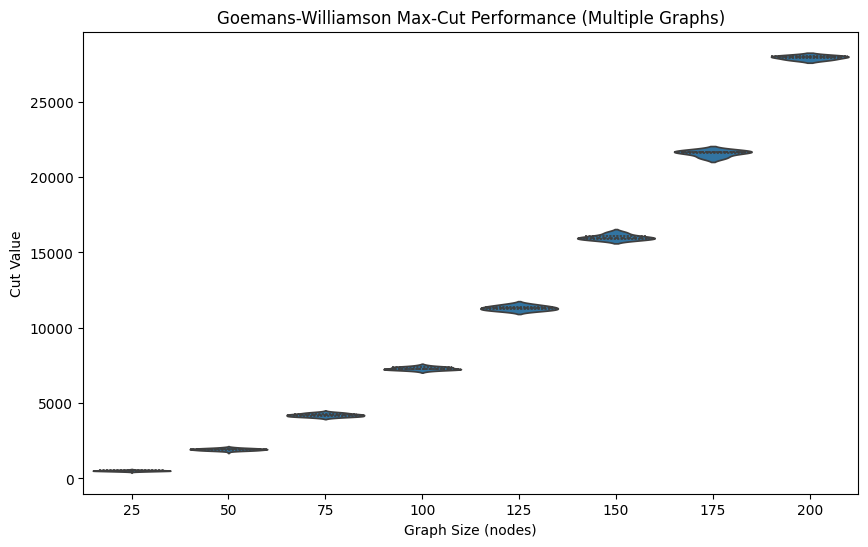

In [12]:
sizes = [25, 50, 75, 100, 125, 150, 175, 200]
edge_prob = 0.5
time_per_size = 40
num_rounds = 50

cut_values = run_gw_experiment_time_budget(sizes, edge_prob, time_per_size, num_rounds)

df = pd.DataFrame({
    'Graph Size': sum([[size]*len(vals) for size, vals in zip(sizes, cut_values)], []),
    'Cut Value': sum(cut_values, [])
})

os.makedirs("data/gw-data", exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
csv_path = f"data/gw-data/gw_{timestamp}.csv"
df.to_csv(csv_path, index=False)
print(f"Results saved to {csv_path}")

plt.figure(figsize=(10,6))
sns.violinplot(x='Graph Size', y='Cut Value', data=df, inner='quartile', scale='width')
plt.title('Goemans-Williamson Max-Cut Performance (Multiple Graphs)')
plt.xlabel('Graph Size (nodes)')
plt.ylabel('Cut Value')
plt.show()